In [18]:
# https://www.tensorflow.org/tutorials/keras/regression

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os

1.14.0


Collect data

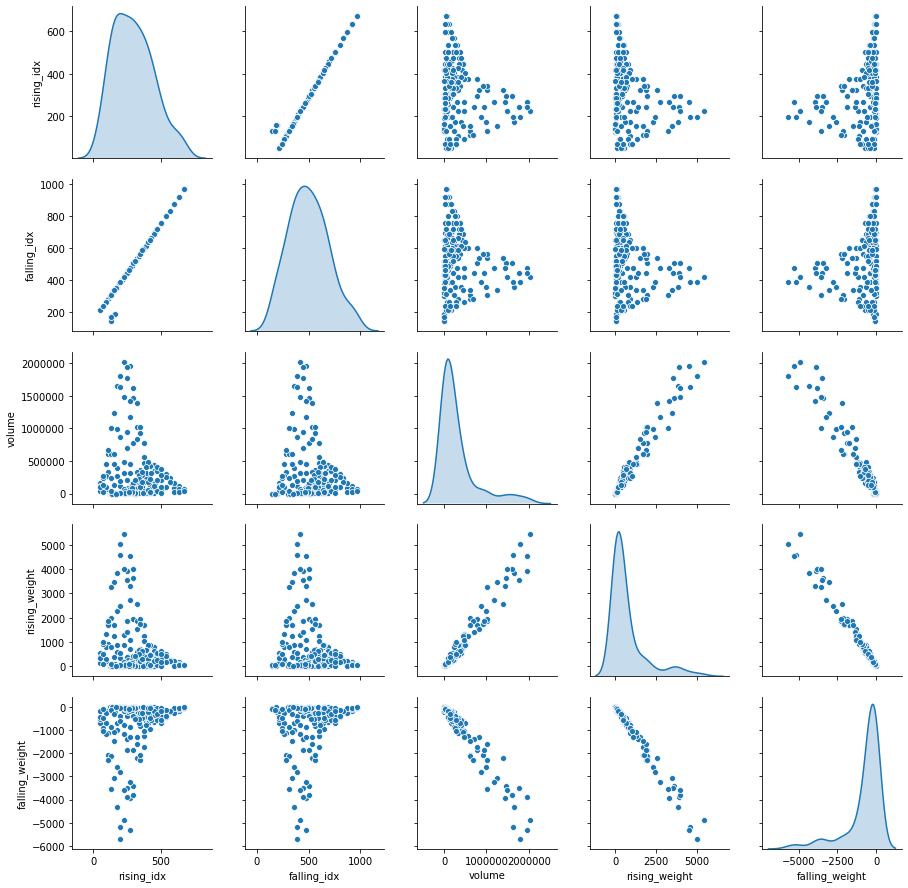

In [12]:


column_names = ['row','rising_idx','falling_idx','volume','rising_weight',
                'falling_weight', 'delay']

raw_dataset = pd.read_csv(os.getenv('DATA_FS') + '../preprocessing/processed.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, usecols = column_names[1:])

dataset = raw_dataset.copy()
dataset.tail()

dataset = dataset.dropna()
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["rising_idx", "falling_idx", "volume", "rising_weight", "falling_weight"]], diag_kind="kde")
train_stats = train_dataset.describe()
train_stats.pop("delay")
train_stats = train_stats.transpose()
train_stats
train_labels = train_dataset.pop('delay')
test_labels = test_dataset.pop('delay')





In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [8]:

model.summary()

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:1628243.0886,  mean_absolute_error:1046.7163,  mean_squared_error:1628243.1250,  val_loss:1231260.7000,  val_mean_absolute_error:919.0081,  val_mean_squared_error:1231260.6250,  
....................................................................................................
Epoch: 100, loss:803612.2603,  mean_absolute_error:719.4368,  mean_squared_error:80361

NameError: name 'plot_model' is not defined

In [19]:

tf.keras.utils.plot_model(model, to_file='model.png')

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)


loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} ns".format(mae))


44/44 - 0s - loss: 1695838.2273 - mean_absolute_error: 1059.7704 - mean_squared_error: 1695838.1250
Testing set Mean Abs Error: 1059.77 ns


In [ ]:
from IPython.display import SVG

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True)
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
i = 0
#activation(dot(input, kernel) + bias)
for layer in model.get_weights():
    print('Layer %d' % i)
    print(layer.shape)
    print(layer)
    i =  i + 1